## Packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
from pyomo.environ import *
from numpy import flatnonzero as find
from pypower.api import case9, ext2int, bustypes, makeBdc, rundcpf, ppoption, rundcopf
from pypower.idx_bus import BUS_TYPE, REF, VA, PD, LAM_P, LAM_Q, MU_VMAX, MU_VMIN
from pypower.idx_gen import PG, MU_PMAX, MU_PMIN, MU_QMAX, MU_QMIN, PMAX, PMIN, GEN_BUS
from pypower.idx_brch import PF, PT, QF, QT, RATE_A, MU_SF, MU_ST
from pypower.idx_cost import COST
import matplotlib.pyplot as plt
import pickle
import os

## Power network parameters

In [2]:
# Run PyPower case to get initial condition
ppc = case9()
ppopt = ppoption(VERBOSE=0)
pp_dcopf = rundcopf(ppc, ppopt)
pp_bus = pp_dcopf["bus"]
pp_branch = pp_dcopf["branch"]
pp_gen = pp_dcopf["gen"]


Converged in 0.10 seconds
Objective Function Value = 5216.03 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0           0.0 to 0.0
Generators         3     On-line Capacity       820.0           0.0 to 0.0
Committed Gens     3     Generation (actual)    315.0               0.0
Loads              3     Load                   315.0               0.0
  Fixed            3       Fixed                315.0               0.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           9     Losses (I^2 * Z)         0.00              0.00
Transformers       0     Branch Charging (inj)     -                0.0
Inter-ties         0     Total Inter-tie F

In [3]:
## convert to internal indexing
ppc = ext2int(ppc)
baseMVA, bus, gen, branch, gencost = \
    ppc["baseMVA"], ppc["bus"], ppc["gen"], ppc["branch"], ppc["gencost"]

## get bus index lists of each type of bus
ref, pv, pq = bustypes(bus, gen)
pvpq = np.matrix(np.r_[pv, pq])

## generator info
gbus = gen[:, GEN_BUS].astype(int)    ## what buses are they at?
refgen = find(gbus == ref)

## build B matrices and phase shift injections
B, Bf, _, _ = makeBdc(baseMVA, bus, branch)
B = B.todense()
Bf = Bf.todense()

# Problem dimensions
NG = gen.shape[0] # Number of generators
NB = bus.shape[0] # Number of buses
NBr = branch.shape[0] # Number of lines
NL = 3 # Number of loads
NW = 1 # Number of wind farms

# Map generator to bus
CG = np.zeros((NB,NG))
CG[gbus,range(3)] = 1

# Map load to bus
CL = np.zeros((NB,NL))
CL[4,0] = 1
CL[6,1] = 1
CL[8,2] = 1

# Map wind farm to bus
CW = np.zeros((NB,1))
CW[5,0] = 1

# Generator capacity limit p.u.
Pmax = gen[:, PMAX]/baseMVA
Pmin = gen[:, PMIN]/baseMVA

# Line flow limit p.u.
Lmax = branch[:, RATE_A]/baseMVA
Lmin = - branch[:, RATE_A]/baseMVA

# Quadratic cost coefficients
# Convert to p.u.
CG2 = gencost[:, COST]*baseMVA**2
CG1 = gencost[:, COST+1]*baseMVA
CG0 = gencost[:, COST+2]

# Cost coefficient for wind power
CW1 = 0
CW0 = 100

# Cost coefficients for generation reserve
CRG_up = 10*np.ones((NG,1))*baseMVA
CRG_down = 10*np.ones((NG,1))*baseMVA

# Cost coefficients for load reserve
CRL_up = 9.8*np.ones((NL,1))*baseMVA
CRL_down = 9.8*np.ones((NL,1))*baseMVA

# Uncontrollable load
PL_total = np.array([90,100,125])
PL = PL_total/baseMVA

# Generator and demand set points
# Power in p.u., Va in rad
Pg0 = pp_gen[:, PG]/baseMVA
Pd0 = pp_bus[:, PD]/baseMVA
Pinj0 = (np.matmul(CG, Pg0) - Pd0)
Va0 = pp_bus[:, VA]/180*np.pi

## Cost function

In [4]:
def cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL):
    r_pg = np.zeros(NG)
    r_rg_up = np.zeros(NG)
    r_rg_down = np.zeros(NG)
    r_rl_up = np.zeros(NL)
    r_rl_down = np.zeros(NL)
    r_pc = np.zeros(NL)
    gen_cost = np.zeros(NG)
    gen_r_cost = np.zeros(NG)
    load_r_cost = np.zeros(NL)


    for i in range(NG):
        r_pg[i] = model.PG[i]()
        r_rg_up[i] = model.RG_up[i]()
        r_rg_down[i] = model.RG_down[i]()
        gen_cost[i] = CG0[i] + CG1[i]*r_pg[i] + CG2[i]*r_pg[i]**2
        gen_r_cost[i] = CRG_up[i]*r_rg_up[i] + CRG_down[i]*r_rg_down[i]

    for i in range(NL):
        r_rl_up[i] = model.RL_up[i]()
        r_rl_down[i] = model.RL_down[i]()
        r_pc[i] = model.PC[i]()
        load_r_cost[i] = CRL_up[i]*r_rl_up[i] + CRL_down[i]*r_rl_down[i]

    total_cost = np.sum(gen_cost + gen_r_cost) + np.sum(load_r_cost)

    return gen_cost,gen_r_cost,load_r_cost,total_cost

## Read results

In [5]:
case_name = "case9_with_DR"
nsample = 453
nhours = 24
figdir = "Figures/"+case_name+"/"
savefig = True

if savefig:
    if not os.path.isdir(figdir):
        os.makedirs(figdir)
        print("Create folder: ", figdir)
    else:
        print(figdir, "folder already exists.")

file = open("Results/models_%s_%d" %(case_name, nsample), "rb")
models = pickle.load(file)
file.close()

# Read PB data
file = open("Results/PB_alls_%s_%d" %(case_name, nsample), "rb")
PB_alls = pickle.load(file)
file.close()

# Read Pmis_wind data
file = open("Results/P_mis_winds_%s_%d" %(case_name, nsample), "rb")
Pmis_winds = pickle.load(file)
file.close()

Figures/case9_with_DR/ folder already exists.


## Sample plots

In [6]:
# Read temperature data
weather_data = pd.read_csv("Weather_Data/NYC_Hourly_Normal_Temp.csv")
# Read wind power data
PW_data = pd.read_csv("spring_wind.csv",header=None).to_numpy()
PW_data = PW_data/500*20/baseMVA

In [7]:
def cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL):
    r_pg = np.zeros(NG)
    r_rg_up = np.zeros(NG)
    r_rg_down = np.zeros(NG)
    r_rl_up = np.zeros(NL)
    r_rl_down = np.zeros(NL)
    r_pc = np.zeros(NL)
    gen_cost = np.zeros(NG)
    gen_r_cost = np.zeros(NG)
    load_r_cost = np.zeros(NL)


    for i in range(NG):
        r_pg[i] = model.PG[i]()
        r_rg_up[i] = model.RG_up[i]()
        r_rg_down[i] = model.RG_down[i]()
        gen_cost[i] = CG0[i] + CG1[i]*r_pg[i] + CG2[i]*r_pg[i]**2
        gen_r_cost[i] = CRG_up[i]*r_rg_up[i] + CRG_down[i]*r_rg_down[i]

    for i in range(NL):
        r_rl_up[i] = model.RL_up[i]()
        r_rl_down[i] = model.RL_down[i]()
        r_pc[i] = model.PC[i]()
        load_r_cost[i] = CRL_up[i]*r_rl_up[i] + CRL_down[i]*r_rl_down[i]

    total_cost = np.sum(gen_cost + gen_r_cost) + np.sum(load_r_cost)

    return gen_cost,gen_r_cost,load_r_cost,total_cost

### Wind power distribution

In [8]:
PW_samples = np.zeros((nhours,nsample))
PW_fs = np.zeros(nhours)
for h in range(nhours):
    np.random.seed(1)
    PW_sample = np.random.choice(PW_data[h,:], size=nsample)
    PW_f = np.median(PW_data[h, :])
    PW_samples[h,:] = PW_sample
    PW_fs[h] = PW_f

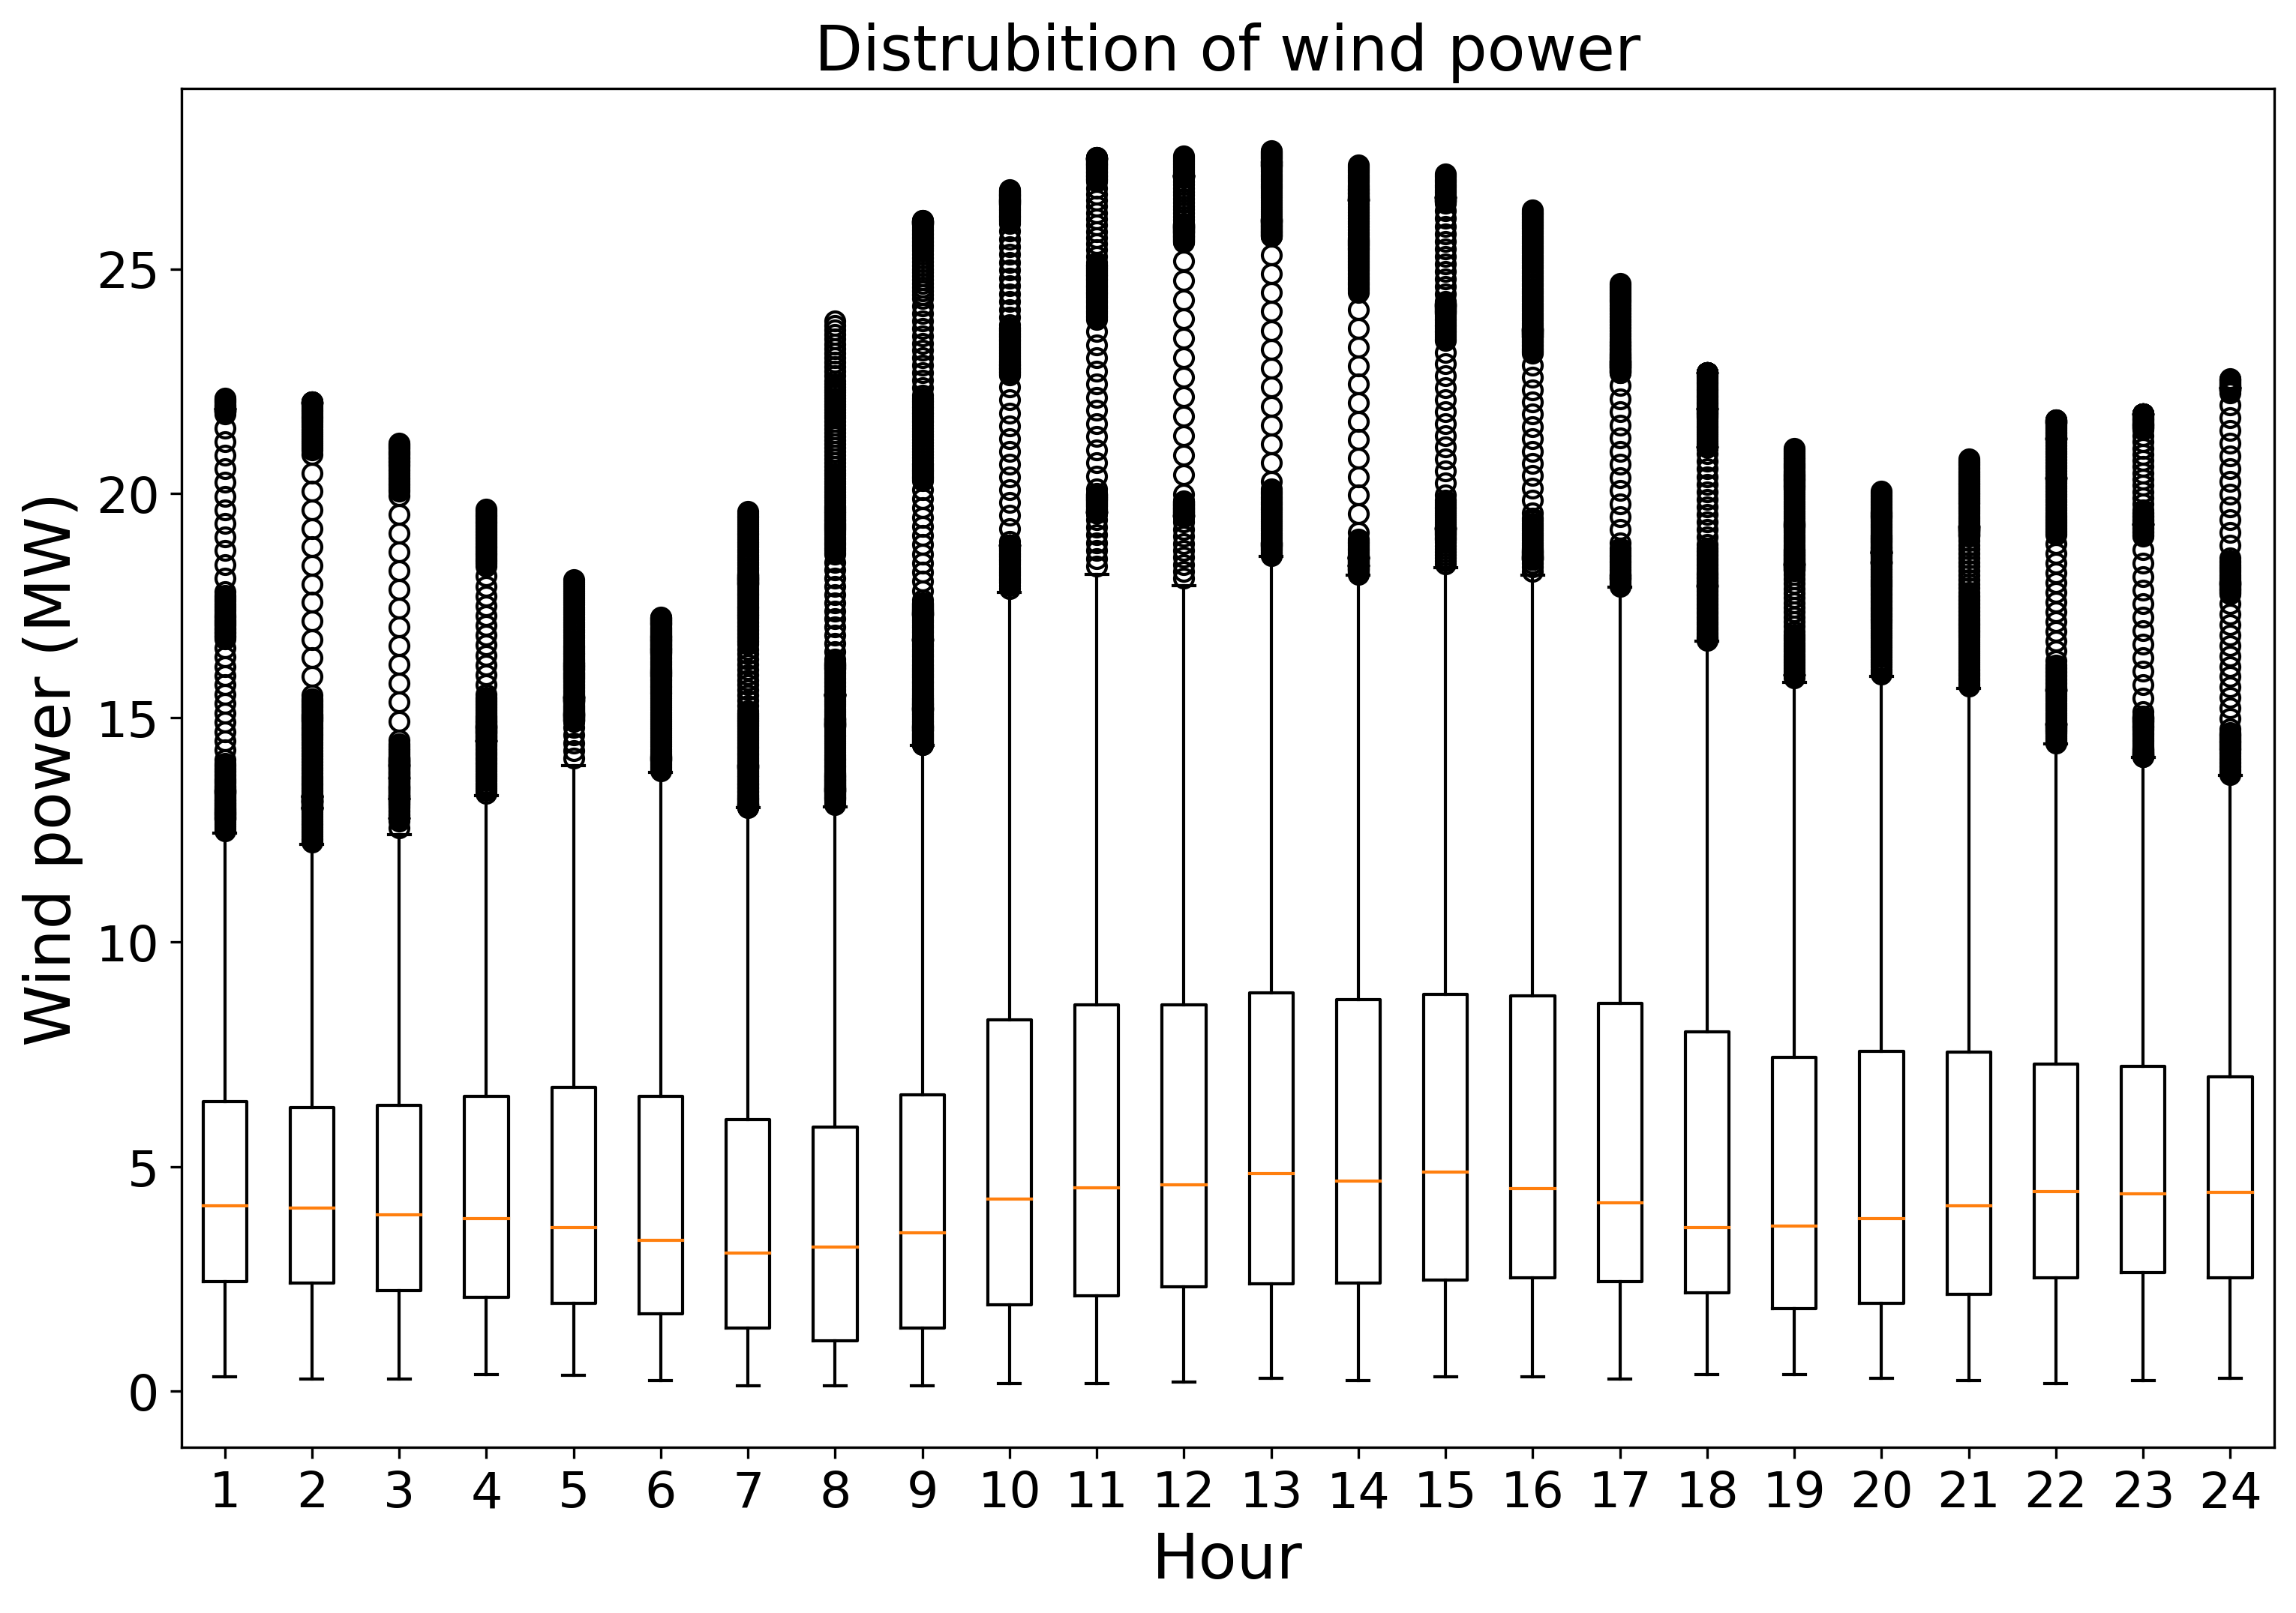

In [11]:
fig = plt.figure(figsize=(12,8), dpi=300)
plt.boxplot(PW_data.T*baseMVA)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Wind power (MW)", fontsize=20)
plt.title("Distrubition of wind power", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig.savefig(figdir+"wind_boxplot.png", dpi=300)
plt.show()

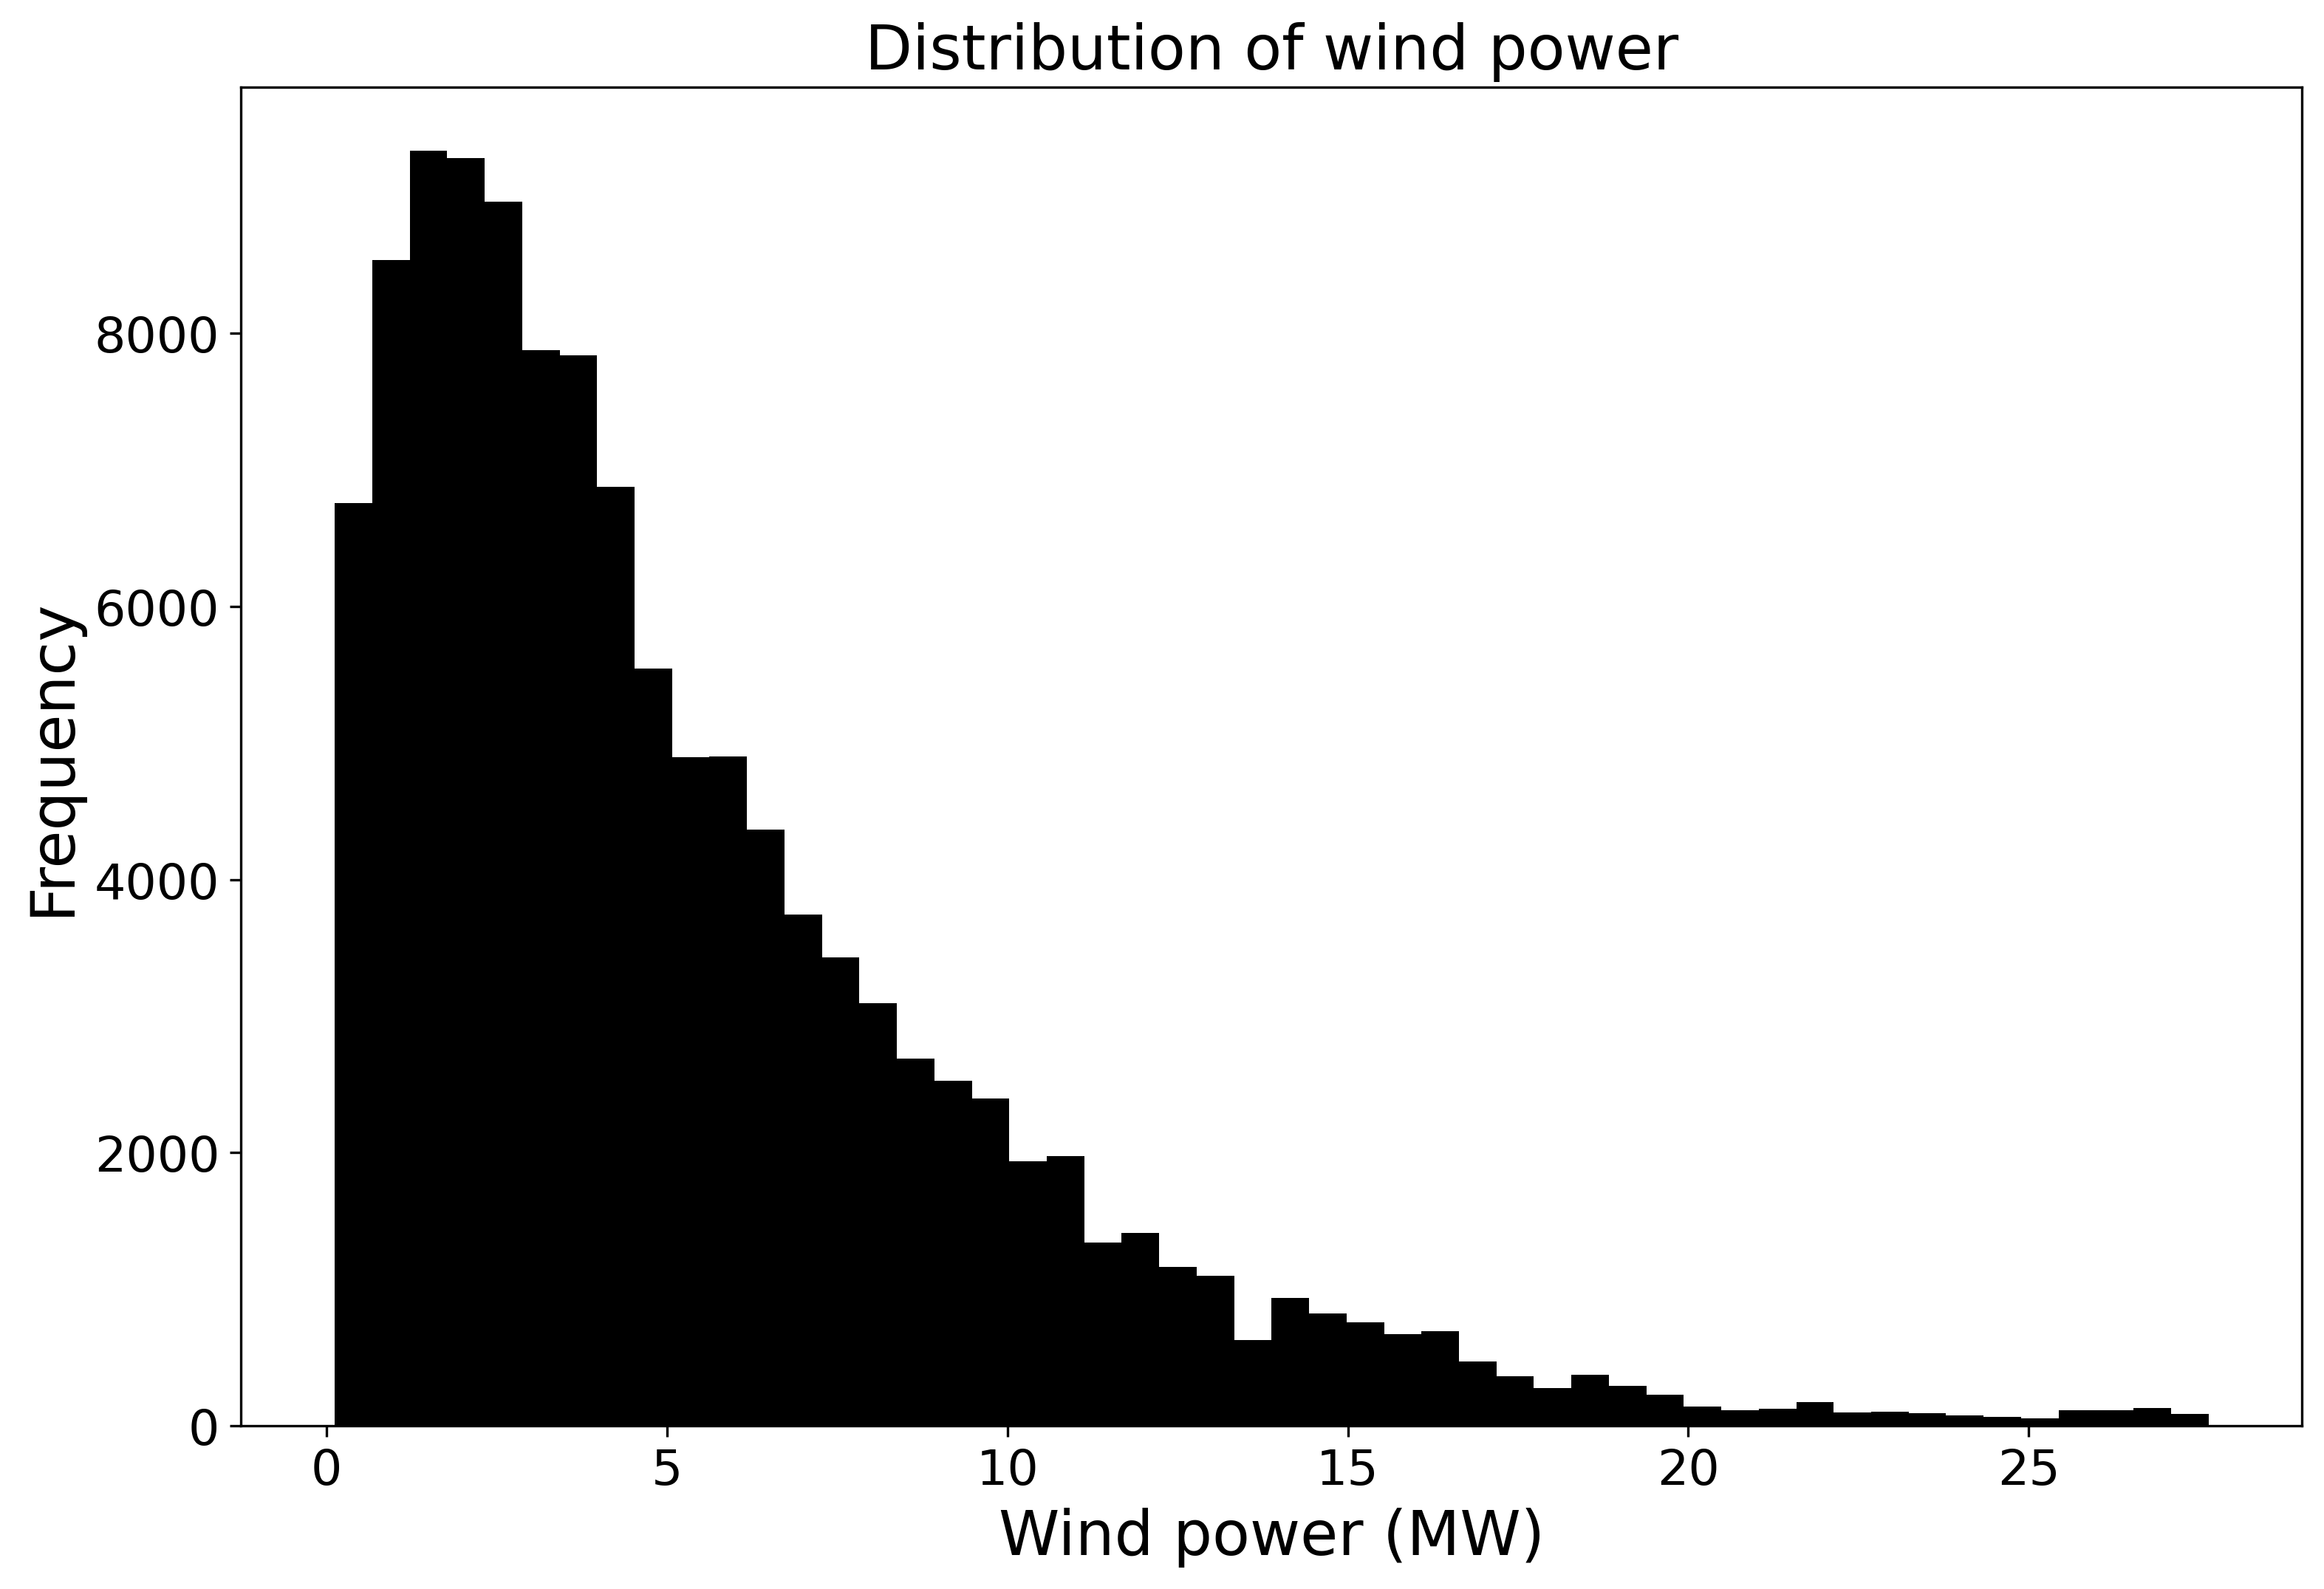

In [10]:
fig = plt.figure(figsize=(12,8), dpi=300)
plt.hist(PW_data.flatten()*baseMVA, bins=50, color="black")
plt.title("Distribution of wind power", fontsize=20)
plt.xlabel("Wind power (MW)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig.savefig(figdir+"Wind_hist.png", dpi=300)
plt.show()

### Virtual storage model

In [ ]:
def VS(dt,Tamb,num_TCL,Tset,delta,R,C,P_el,COP,baseMVA):
    Tdown = np.zeros(num_TCL)
    Tup = np.zeros(num_TCL)
    T_ON = np.zeros(num_TCL)
    T_OFF = np.zeros(num_TCL)
    D = np.zeros(num_TCL)
    B = 0
    Pdown = 0
    Pup = 0
    Sdown = 0
    Sup = 0
    for i in range(0,num_TCL):
        Tdown[i] = Tset[i] - delta/2
        Tup[i] = Tset[i] + delta/2
        T_ON[i] = C[i]*R[i]*np.log((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]))
        if ((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]) < 0):
            print(Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])
            print(Tup[i] - Tamb - R[i]*P_el[i]*COP[i])
        T_OFF[i] = C[i]*R[i]*np.log((Tup[i] - Tamb)/(Tdown[i] - Tamb))
        D[i] = T_ON[i]/(T_ON[i] + T_OFF[i])
        if ( Tamb < Tdown[i] and Tamb + R[i]*P_el[i]*COP[i] > Tup[i] ):
            B = B + P_el[i]*D[i]
            Pup = Pup + P_el[i]
            Sup = Sup + dt*P_el[i]*(1 - D[i])
    return [B/1000/baseMVA,Pdown/1000/baseMVA,Pup/1000/baseMVA,Sdown,Sup]

### Load parameters

In [ ]:
Tamb = (weather_data.iloc[:,8] - 32)/1.8
Tamb_min = min(Tamb)
Tamb_10PCTL = (weather_data.iloc[:,6] - 32)/1.8
Tamb_90PCTL = (weather_data.iloc[:,7] - 32)/1.8
std_Tamb_10PCTL = (Tamb - Tamb_10PCTL)/1.282 
std_Tamb_90PCTL = (Tamb_90PCTL - Tamb)/1.282 
std_Tamb = (std_Tamb_10PCTL + std_Tamb_90PCTL)/10

# Parameters related to the demand side
num_TCL = 5000
Tset = np.zeros((num_TCL,NL))
R = np.zeros((num_TCL,NL))
C = np.zeros((num_TCL,NL))
COP = np.zeros((num_TCL,NL))
P_el = np.zeros((num_TCL,NL))
Tset_set = [21,21.5,22,22.5,23]
for i in range(num_TCL): 
    for j in range(NL):
        s = random.sample(Tset_set,1)
        Tset[i,j] = s[0] 
delta = 1
R_nom = 2
R_low = 0.8*R_nom
R_high = 1.2*R_nom
C_nom = 2
C_low = 0.8*C_nom
C_high = 1.2*C_nom
COP_nom = 2.5
COP_low = 0.8*COP_nom
COP_high = 1.2*COP_nom

np.random.seed(0)

for i in range(NL): 
    R[:,i] = np.random.uniform(R_low,R_high,num_TCL)
    C[:,i] = np.random.uniform(C_low,C_high,num_TCL)
    COP[:,i] = np.random.uniform(COP_low,COP_high,num_TCL)
    for j in range(num_TCL):
        P_el[j,i] = np.ceil((Tset[j,i] + delta/2 - Tamb_min)/(R[j,i]*COP[j,i])) + 3


### Baseline load, maximum energy capacity and ambient temperature histogram

In [ ]:
# nsample_test = 10000
# PB = np.zeros(nsample_test)
# S_up = np.zeros(nsample_test)
# np.random.seed(1)
# Tamb_sample = np.random.normal(Tamb[0],std_Tamb[0],nsample_test)
# for i in range(nsample_test):
#     identified_VS = VS(0.25,Tamb_sample[i],num_TCL,Tset[:,0],delta,R[:,0],C[:,0],P_el[:,0],COP[:,0],baseMVA)
#     PB[i] = identified_VS[0]
#     S_up[i] = identified_VS[4]

In [ ]:
# fig1 = plt.figure(figsize=(12,8), dpi=300)
# plt.tight_layout()
# plt.hist(PB*baseMVA, bins=50, color="black")
# plt.title("Distribution of baseline power consumption", fontsize=20)
# plt.xlabel("Baseline power consumption (MW)", fontsize=20)
# plt.ylabel("Frequency", fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# fig1.savefig(figdir+"PB_hist.png", dpi=300)
# plt.show()

# fig2 = plt.figure(figsize=(12,8), dpi=300)
# plt.tight_layout()
# plt.hist(S_up/1000, bins=50, color="black")
# plt.title("Distribution of maximum energy capacity of the virtual storage", fontsize=20)
# plt.xlabel("Maximum energy capacity (MWh)", fontsize=20)
# plt.ylabel("Frequency", fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# fig2.savefig(figdir+"Sup_hist.png", dpi=300)
# plt.show()

# fig3 = plt.figure(figsize=(12,8), dpi=300)
# plt.tight_layout()
# plt.hist(Tamb_sample, bins=50, color="black")
# plt.title("Distribution of ambient temperature", fontsize=20)
# plt.xlabel(u"Abmient temperature (\N{DEGREE SIGN}C)", fontsize=20)
# plt.ylabel("Frequency", fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# fig3.savefig(figdir+"Tamb_hist.png", dpi=300)
# plt.show()

## Reserve plots

### RG boxplot

In [ ]:
# Read RG data
RG_all_hour = np.zeros((NG, nhours, nsample))

for h in range(nhours):
    model = models[h]
    RG_all = model.RG[:,:]()
    RG_all = np.array(RG_all).reshape(NG, nsample)*baseMVA

    for i in range(NG):
        RG_one = RG_all[i, :]
        RG_all_hour[i, h, :] = RG_one

# RG boxplot
gen_bus = [1, 2, 3]

for i in range(NG):
    fig = plt.figure(figsize=(12,8), dpi=300)
    RG_plot = RG_all_hour[i, :, :].tolist()
    plt.boxplot(RG_plot)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Generator reserve (MW)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if savefig:
        fig_name = figdir+"RG_%i.png" %i
        fig.savefig(fig_name, dpi=300)
    plt.show()

### RG up and down bar plot

In [ ]:
# Read RG up and down data
RG_up_all_hour = np.zeros((NG, nhours))
RG_down_all_hour = np.zeros((NG, nhours))

for h in range(nhours):
    model = models[h]
    RG_up_all = model.RG_up[:]()
    RG_down_all = model.RG_down[:]()
    RG_up_all = np.array(RG_up_all).reshape(NG)*baseMVA
    RG_down_all = np.array(RG_down_all).reshape(NG)*baseMVA

    for i in range(NG):
        RG_up_one = RG_up_all[i]
        RG_down_one = RG_down_all[i]
        RG_up_all_hour[i, h] = RG_up_one
        RG_down_all_hour[i, h] = RG_down_one

# Plot RG up and down data
for i in range(NG):
    # print("Generator: ", i)
    fig = plt.figure(figsize=(12,8), dpi=300)

    RG_up_plot = RG_up_all_hour[i, :]
    # print("RG up: ", RG_up_plot)
    plt.bar(range(1,nhours+1),RG_up_plot, label="Upward reserve")

    RG_down_plot = RG_down_all_hour[i, :]
    # print("RG down: ", RG_down_plot)
    plt.bar(range(1,nhours+1),-RG_down_plot, color='r', label="Downward reserve")

    plt.legend(fontsize=16)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Reserve (MW)", fontsize=20)
    plt.xticks(range(1,nhours+1), fontsize=16)
    plt.yticks(fontsize=16)
    if savefig:
        fig_name = figdir+"RG_up_down_%i.png" %i
        fig.savefig(fig_name, dpi=300)
    

### RL boxplot

In [ ]:
# Read RL data
RL_all_hour = np.zeros((NL, nhours, nsample))

for h in range(nhours):
    model = models[h]
    RL_all = model.RL[:,:]()
    RL_all = np.array(RL_all).reshape(NL, nsample)*baseMVA

    for i in range(NL):
        RL_one = RL_all[i, :]
        RL_all_hour[i, h, :] = RL_one

# RL boxplot
load_bus = [5, 7, 9]

for i in range(NL):
    fig = plt.figure(figsize=(12,8), dpi=300)
    RL_plot = RL_all_hour[i, :, :].tolist()
    plt.boxplot(RL_plot)
    plt.title("Load %d - Bus %d" %((i+1), load_bus[i]), fontsize=20)
    plt.xlabel("Hour",fontsize=20)
    plt.ylabel("Load reserve (MW)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    if savefig:
        fig_name = figdir+"RL_%d.png" %i
        fig.savefig(fig_name, dpi=300)

### RL up and down bar plot

In [ ]:
# Read RL up and down data
RL_up_all_hour = np.zeros((NL, nhours))
RL_down_all_hour = np.zeros((NL, nhours))

for h in range(nhours):
    model = models[h]
    RL_up_all = model.RL_up[:]()
    RL_down_all = model.RL_down[:]()
    RL_up_all = np.array(RL_up_all).reshape(NL)*baseMVA
    RL_down_all = np.array(RL_down_all).reshape(NL)*baseMVA

    for i in range(NL):
        RL_up_one = RL_up_all[i]
        RL_down_one = RL_down_all[i]
        RL_up_all_hour[i, h] = RL_up_one
        RL_down_all_hour[i, h] = RL_down_one

# Plot RG up and down data
for i in range(NL):

    # print("Load: ", i)
    fig = plt.figure(figsize=(12,8), dpi=300)

    RL_up_plot = RL_up_all_hour[i, :]
    # print("RL up: ", RL_up_plot)
    plt.bar(range(1,nhours+1),RL_up_plot, label="Upward reserve")

    RL_down_plot = RL_down_all_hour[i, :]
    # print("RL down: ", RL_down_plot)
    plt.bar(range(1,nhours+1),-RL_down_plot, color='r', label="Downward reserve")

    plt.legend(fontsize=16)
    plt.title("Load %d - Bus %d" %((i+1), load_bus[i]), fontsize=20)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Reserve (MW)", fontsize=20)
    plt.xticks(range(1,nhours+1), fontsize=16)
    plt.yticks(fontsize=16)
    if savefig:
        fig_name = figdir+"RL_up_down_%i.png" %i
        fig.savefig(fig_name, dpi=300)

## Power mismatch plot

### Wind mismatch boxplot

In [ ]:
# Calculate wind mismatch
Pmis_wind_hour = np.zeros((nhours, nsample))
for h in range(nhours):
    Pmis_wind = Pmis_winds[h]
    Pmis_wind = np.array(Pmis_wind).reshape(nsample)*baseMVA
    Pmis_wind_hour[h, :] = Pmis_wind

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=300)
Pmis_wind_plot = Pmis_wind_hour.tolist()
plt.boxplot(Pmis_wind_plot)
plt.title("Wind mismatch", fontsize=20)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Mismatch (MW)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig_name = figdir+"Wind_mismatch.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

In [ ]:
# Load power set point
PB_all_hour = np.zeros((NL, nhours, nsample))
for h in range(nhours):
    PB_all = PB_alls[h]
    PB_all = np.array(PB_all).reshape(NL, nsample)*baseMVA

    for i in range(NL):
        PB_one = PB_all[i, :]
        PB_all_hour[i, h, :] = PB_one

In [ ]:
# Read PC data
PC_all_hour = np.zeros((NL, nhours))

for h in range(nhours):
    model = models[h]
    PC_all = model.PC[:]()
    PC_all = np.array(PC_all).reshape(NL)*baseMVA

    for i in range(NL):
        PC_one = PC_all[i]
        PC_all_hour[i, h] = PC_one

### Load set point and reserve line plot

In [ ]:
for i in range(NL):
    fig = plt.figure(figsize=(12,8), dpi=300)
    plt.plot(range(1,nhours+1), PC_all_hour[i, :], linestyle="-", marker="o", color="black", label="Baseline load")
    plt.plot(range(1,nhours+1), PC_all_hour[i, :] + RL_up_all_hour[i, :], linestyle="dashed", marker="o", color="red", label="Maximum load")
    plt.plot(range(1,nhours+1), PC_all_hour[i, :] - RL_down_all_hour[i, :], linestyle="dashed", marker="o", color="blue", label="Minimum load")
    plt.fill_between(range(1,nhours+1), PC_all_hour[i, :], PC_all_hour[i, :] + RL_up_all_hour[i, :], color="red", alpha=0.1)
    plt.fill_between(range(1,nhours+1), PC_all_hour[i, :], PC_all_hour[i, :] - RL_down_all_hour[i, :], color="blue", alpha=0.1)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Controllable load (MW)", fontsize=20)
    plt.title("Load %d - Bus %d" %((i+1), load_bus[i]), fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(range(1,nhours+1), fontsize=16)
    plt.yticks(fontsize=16)
    if savefig:
        fig_name = figdir+"Load_PC_RL_up_down_%d.png" %i
        fig.savefig(fig_name, dpi=300)
    plt.show()

### Total power mismatch boxplot

In [ ]:
Pmis_all_hour = np.zeros((nhours,nsample))
# Calculate P mis
for h in range(nhours):
    for i in range(nsample):
        Pmis_all_hour[h,i] = Pmis_wind_hour[h,i] - np.sum(PC_all_hour[:, h]) + np.sum(PB_all_hour[:, h, i])

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=300)
Pmis_plot = Pmis_all_hour[:, :].tolist()
plt.boxplot(Pmis_plot)
plt.title("Power mismatch", fontsize=20)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Mismatch (MW)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig_name = figdir+"Power_mismatch.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

## Power generation plot
### Power generation bar plot

In [ ]:
# Read PG data
PG_all_hour = np.zeros((NG, nhours))
PG_sum_hour = np.zeros(nhours)
PW_f_hour = np.zeros(nhours)

for h in range(nhours):
    model = models[h]
    PG_all = model.PG[:]()
    PG_all = np.array(PG_all).reshape(NG)*baseMVA

    for i in range(NG):
        PG_one = PG_all[i]
        PG_all_hour[i, h] = PG_one

    PG_sum_hour[h] = np.sum(PG_all_hour[:,h])

    # Wind power forecast
    PW_f_hour[h] = np.median(PW_data[h, :])*baseMVA

fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(1,nhours+1), PG_all_hour[0], label="Generator 1")
plt.bar(range(1,nhours+1), PG_all_hour[1], bottom=PG_all_hour[0], label="Generator 2")
plt.bar(range(1,nhours+1), PG_all_hour[2], bottom=PG_all_hour[0]+PG_all_hour[1], label="Generator 3")
# plt.bar(range(nhours), PW_f_hour, bottom=PG_all_hour[0]+PG_all_hour[1]+PG_all_hour[2], label="Wind")

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Generation (MW)", fontsize=20)
plt.ylim(0, 500)
plt.title("Generation", fontsize=20)
plt.xticks(range(1,nhours+1), fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
if savefig:
    fig_name = figdir+"Generation.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

### Power generation line plot

In [ ]:
for i in range(NG):
    fig = plt.figure(figsize=(12,8), dpi=300)
    plt.plot(range(1,nhours+1), PG_all_hour[i], linestyle="-", marker="o", color="black", label="Baseline generation")
    plt.plot(range(1,nhours+1), PG_all_hour[i] + RG_up_all_hour[i, :], linestyle="--", marker="o", color="red", label="Maximum generation")
    plt.plot(range(1,nhours+1), PG_all_hour[i] - RG_down_all_hour[i, :], linestyle="--", marker="o", color="blue", label="Minimum generation")
    plt.fill_between(range(1,nhours+1), PG_all_hour[i], PG_all_hour[i] + RG_up_all_hour[i, :], facecolor="red", alpha=0.1)
    plt.fill_between(range(1,nhours+1), PG_all_hour[i], PG_all_hour[i] - RG_down_all_hour[i, :], facecolor="blue", alpha=0.1)
    plt.legend(fontsize=16)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Generation (MW)", fontsize=20)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xticks(range(1,nhours+1), fontsize=16)
    plt.yticks(fontsize=16)
    if savefig:
        fig_name = figdir+"PG_RG_up_down_%d" %i
        fig.savefig(fig_name, dpi=300)
    plt.show()

## Cost plots
### Generator cost curve

In [ ]:
# Plot cost curve
fig = plt.figure(figsize=(12,8), dpi=300)

for i in range(NG):
    x = np.linspace(Pmin[i]*baseMVA, Pmax[i]*baseMVA, 1000)
    gencost = CG0[i] + CG1[i]/baseMVA * x +  CG2[i]/baseMVA**2 * x**2
    plt.plot(x, gencost, label="Generator %d" %(i+1))

plt.legend(fontsize=16)
plt.xlabel("Generation (MW)", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator cost curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig_name = figdir+"Gen_cost_curve.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

### Generator marginal cost curve

In [ ]:
# Plot cost curve
fig = plt.figure(figsize=(12,8), dpi=300)

for i in range(NG):
    x = np.linspace(Pmin[i]*baseMVA, Pmax[i]*baseMVA, 1000)
    genmc = CG1[i]/baseMVA +  CG2[i]/baseMVA**2 * x
    plt.plot(x, genmc, label="Generator %d" %(i+1))

plt.legend(fontsize=16)
plt.xlabel("Generation (MW)", fontsize=20)
plt.ylabel("Marginal cost ($/MW)", fontsize=20)
plt.title("Generator marginal cost curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if savefig:
    fig_name = figdir+"Gen_marginal_cost_curve.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

In [ ]:
# Calculate different costs

gen_cost_hour = np.zeros((NG,nhours))
gen_r_cost_hour = np.zeros((NG,nhours))
load_r_cost_hour = np.zeros((NL,nhours))
total_cost_hour = np.zeros(nhours)

for h in range(nhours):
    gen_cost,gen_r_cost,load_r_cost,total_cost = cost(models[h],CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL)
    gen_cost_hour[:,h] = gen_cost
    gen_r_cost_hour[:,h] = gen_r_cost
    load_r_cost_hour[:,h] = load_r_cost
    total_cost_hour[h] = total_cost

### Generation cost bar plot

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(1,nhours+1), gen_cost_hour[0, :], label="Generator 1")
plt.bar(range(1,nhours+1), gen_cost_hour[1, :], bottom=gen_cost_hour[0, :], label="Generator 2")
plt.bar(range(1,nhours+1), gen_cost_hour[2, :], bottom=gen_cost_hour[1, :]+gen_cost_hour[0, :], label="Generator 3")

plt.legend(fontsize=16)
plt.xticks(range(1,nhours+1), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 9000)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator cost", fontsize=20)
if savefig:
    fig.savefig(figdir+"gen_cost.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(1,nhours+1), gen_r_cost_hour[0, :], label="Generator 1")
plt.bar(range(1,nhours+1), gen_r_cost_hour[1, :], bottom=gen_r_cost_hour[0, :], label="Generator 2")
plt.bar(range(1,nhours+1), gen_r_cost_hour[2, :], bottom=gen_r_cost_hour[1, :]+gen_r_cost_hour[0, :], label="Generator 3")

plt.legend(fontsize=16)
plt.xticks(range(1,nhours+1), fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0, 200)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator reserve cost", fontsize=20)
if savefig:
    fig.savefig(figdir+"gen_reserve_cost.png", dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(1,nhours+1), load_r_cost_hour[0, :], label="Load 1")
plt.bar(range(1,nhours+1), load_r_cost_hour[1, :], bottom=load_r_cost_hour[0, :], label="Load 2")
plt.bar(range(1,nhours+1), load_r_cost_hour[2, :], bottom=load_r_cost_hour[1, :]+load_r_cost_hour[0, :], label="Load 3")

plt.legend(fontsize=16)
plt.xticks(range(1,nhours+1), fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0, 200)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Load reserve cost", fontsize=20)
if savefig:
    fig.savefig(figdir+"load_reserve_cost.png", dpi=300)
plt.show()

### Total cost contribution bar plot

In [ ]:
wind_cost = CW0 + CW1*PW_f_hour
total_gen_cost = gen_cost_hour[2, :]+gen_cost_hour[1, :]+gen_cost_hour[0, :]
total_gen_r_cost = gen_r_cost_hour[2, :]+gen_r_cost_hour[1, :]+gen_r_cost_hour[0, :]
total_load_r_cost = load_r_cost_hour[2, :]+load_r_cost_hour[1, :]+load_r_cost_hour[0, :]
total_reserve_cost = total_gen_r_cost + total_load_r_cost

fig = plt.figure(figsize=(12,8), dpi=300)
plt.bar(range(1,nhours+1),total_gen_cost, label="Generation cost")
plt.bar(range(1,nhours+1),wind_cost, bottom=total_gen_cost, label="Expected wind cost")
plt.bar(range(1,nhours+1),total_gen_r_cost, bottom=total_gen_cost+wind_cost, label="Generation reserve cost")
plt.bar(range(1,nhours+1),total_load_r_cost, bottom=total_gen_cost+wind_cost+total_gen_r_cost, label="Load reserve cost")

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Total cost ($)", fontsize=20)
plt.title("Contribution of generation and reserves to the total cost", fontsize=20)
plt.legend(fontsize=16)
plt.xticks(range(1,nhours+1), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,10000)
if savefig:
    fig_name = figdir+"cost_contribution.png"
    fig.savefig(fig_name, dpi=300)
plt.show()

In [ ]:
print("Wind cost = \n", wind_cost)
print("Total generation cost = \n", total_gen_cost)
print("Total generation reserve cost = \n", total_gen_r_cost)
print("Total load reserve cost = \n", total_load_r_cost)
print("Total reserve cost = \n", total_reserve_cost)
print("total cost = \n", total_gen_cost + total_gen_r_cost + wind_cost + total_load_r_cost)